## Image Reconstruction

High-dimensional data--today we'll work with images--is common and informative but often difficult to manipulate. One method we can use originates from the "[manifold hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis)". The manifold hypothesis posits that high-dimensional data really exists on a low-dimensional subspace *in* the high-dimensional space. So, if we can find the subspace, we can compress the original data and even generate *new* data by sampling from the subspace directly.

## Singular Value Decomposition

We'll start by using Singular Value Decomposition (SVD) to compress an image. Recall that the SVD is a generalization of the eigendecomposition, allowing us to decompose a non-square matrix into three structured matrices.

Consider a matrix $A \in \mathbb{R}^{b \times c}$. The SVD is given by $A = U S V^\top$ where the columns of $U$ and $V$ form an orthonormal basis while $S$ is a diagonal matrix with singular values on its diagonals. Equivalently, we can write

$$A = \sum_{i=1}^{\min \{b,c\}} s_i u_i v_i^\top$$

where singular value $s_i$ is the $i$th diagonal entry of $S$ and $u_i, v_i$ are the $i$th columns of $U, V$. Note that the singular values tell us the *importance* of each vector outer product. If $s_i$ is large, then a large part of $A$ comes from $u_i v_i^\top$ while if $s_i$ is small, we can probably ignore $u_i v_i^\top$.

Now how does SVD relate to images? Well, as we know, images are matrices of pixels. (Of course, colorful images are *three* matrices of pixels but we can deal with each color separately.) If we could find the SVD of the pixel matrix, we could use only the most important singular values to represent the image. And that's exactly what we're about to do.

We'll begin by importing a few helpful libraries.


In [1]:
import scipy
import urllib.request
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Now, as we've done in prior labs, we'll load an image from the internet. I chose [this](https://rarehistoricalphotos.com/wp-content/uploads/2022/06/albert-einstein-tongue-3.webp) image of Einstein but you can also opt for another of your choice.

In [2]:
# Load the image into a tensor like we've done in prior labs.
loader = transforms.Compose([
  transforms.ToTensor(),
])

def load_image(link, filename):
  urllib.request.urlretrieve(link, f'{filename}.png') # Save link as an image.
  image = Image.open(f'{filename}.png') # Load saved image.
  image = loader(image)
  return image

image_link = "https://rarehistoricalphotos.com/wp-content/uploads/2022/06/albert-einstein-tongue-3.webp"

image = load_image(image_link, 'image')

Just to make sure everything went smoothly, let's take a look.

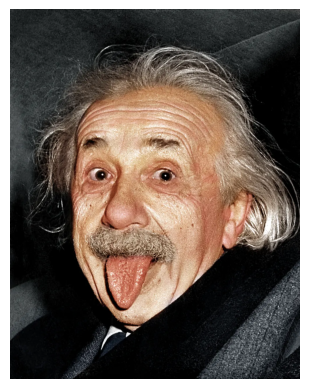

In [3]:
plt.imshow(transforms.ToPILImage()(image))
plt.axis('off')
plt.show()

Now let's find the SVD of the image. Fortunately, pytorch has a `torch.svd` function that can even take in batches of matrices.

In [4]:
U, S, V = torch.svd(image)

Now let's check that the dimensions work out. If your original image has shape $a \times b \times c$, then:

* $U$ should be $a \times b \times \min \{b,c\}$,

* $S$ should be $a \times \min \{b,c\}$,

* and $V$ should be $a \times c \times \min \{b, c\}$.

Note: By convention, $S$ holds vectors instead of matrices.

In [5]:
# Make sure the shape of U,S,V make sense.
print(U.shape)
print(S.shape)
print(V.shape)

torch.Size([3, 1277, 1000])
torch.Size([3, 1000])
torch.Size([3, 1000, 1000])


Before we compress the image, let's take a look at the singular values. If the largest singular values are all the same size, then we'd conclude that the top singular vectors are pretty important. However, if the largest singular values get small quickly, then we may be able to recover the image with only a few of them.

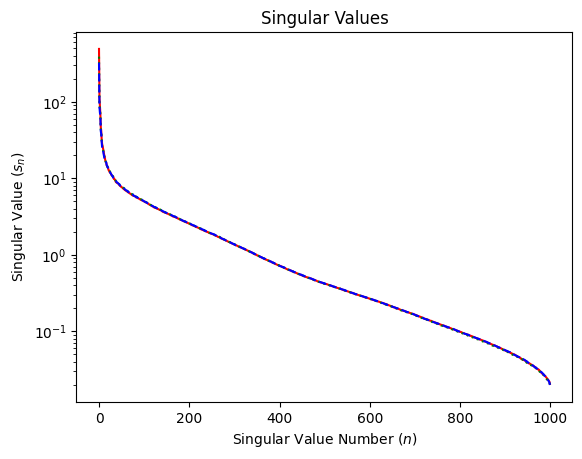

In [6]:
xs = list(range(len(S[0])))
plt.plot(xs, S[0].numpy(), label='Red', color='red', linestyle='solid')
plt.plot(xs, S[1].numpy(), label='Green', color='green', linestyle='dotted')
plt.plot(xs, S[2].numpy(), label='Blue', color='blue', linestyle='dashed')
plt.title('Singular Values')
plt.ylabel('Singular Value $(s_n)$')
plt.xlabel('Singular Value Number $(n)$')
plt.yscale('log') # logarithmic scale
plt.show()

The plot shows a logarithmic scale. Try turning the logarithmic scale on and off to get a sense for how quickly the singular values fall off (simply comment or uncomment the appropriate line). On all the images I've tried, the singular values fall off very quickly. This suggests that approximating the image with only a few singular vectors is a good idea. Let's continue then!

We'll write a function which considers each channel (matrix) in the image (so make sure your image has shape $a \times b \times c$). Now the cool part of the SVD is that we can use it even if we only consider the top $k$ singular values and vectors. Define:

* the first $k$ columns of $U$ as $U_k \in \mathbb{R}^{b \times k}$,

* the first $k$ singular values of $S$ as $S_k \in \mathbb{R}^{k \times k}$,

* and the first $k$ columns of $V$ as $V_k \in \mathbb{R}^{c \times k}$.

Notice that the dimensions work out: $U_k S_k V_k^\top$ is still a $b \times c$ matrix.

In [7]:
def approximate_image(U, S, V, k):
  image_approx = []
  for channel in range(len(V)):
    # Extract the top k singular values and vectors.
    # Hint: Consider each channel (matrix) of U,S,V separately.
    # Hint: Use torch.diag to turn the vector in S into a matrix.
    topU = U[channel, :, :k]
    topS = torch.diag(S[channel, :k])
    topV = V[channel, :, :k]
    channel_approx = topU @ topS @ topV.T
    image_approx += [channel_approx.unsqueeze(0)]
  # Make a new tensor from the list of tensors.
  image_approx = torch.cat(image_approx)
  # Ensure all the pixel values fall in the correct range.
  image_approx = image_approx.clamp(0,1)
  return image_approx

Now that we've implemented a handy function for approximating an image, let's try it with different values of $k$.

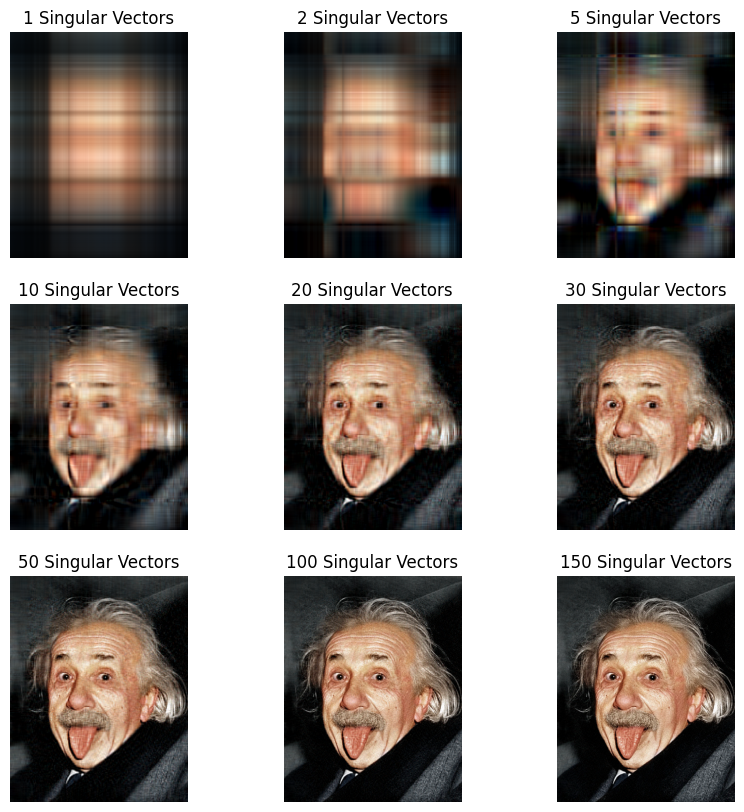

In [8]:
# Feel free to change the figsize so that your images display nicely.
figure, axes = plt.subplots(3, 3, figsize=(10,10))
# Feel free to change which 9 values of k you try.
ks = [1,2,5,10,20,30,50,100,150]
for axis, k in zip(axes.flatten(), ks):
  image_approx = approximate_image(U, S, V, k)
  image = transforms.ToPILImage()(image_approx)
  axis.imshow(image)
  axis.axis('off')
  axis.set_title(f'{k} Singular Vectors')
plt.show()

Of course, the approximations with a few singular values are quite poor but we really don't need that many to get a good sense of the image. For the image I chose, the approximations with $k \geq 30$ all look the same as the original image!

So, by finding the SVD of an image, we managed to compress into an outerproduct of only $k$ singular values and vectors. The original image took $abc$ numbers to store. How many numbers do we need to store an approximation with $k$ singular values and vectors?

## Autoencoders

We were able to compress an image using SVD but there are two issues that leave us unsatisfied:

1. The compressed space for each image still depended on the original image size. It would be nice if we could get a compression that is *independent* of the original image.

2. It's not clear how to generate *new* realistic images. It would be nice if we could directly sample from the subspace and get pretty outputs.

Autoencoders will give us a chance to solve both issues. The idea is to train one neural network to encode the original image in a compressed *latent* space and another neural network to decode the latent representation back to the original image.

The below figure shows the high level idea of an autoencoder. (Figure from [here](https://www.i2tutorials.com/explain-about-auto-encoder-details-about-encoder-decoder-and-bottleneck/).)

![](https://www.i2tutorials.com/wp-content/media/2019/09/Auto-Encoder-i2tutorials.png)

The process on the left encodes the image to a vector in the latent space while the process on the right decodes the latent vector to the original image. Of course, we don't expect any old neural network to work so we'll need to define an appropriate loss function and apply an optimization procedure.

Let's view the process through our three step recipe for machine learning algorithms:

1. **Model**. The model consists of an encoder and decoder where the parameters of each are trainable.

2. **Loss**. The loss is the difference between the original image and the reconstructed image. If the two images are close, then the loss will be low.

3. **Optimizer**. The optimizer is gradient descent where we update the parameters in the encoder and decoder to minimize the loss.

As usual, we'll begin by loading several helpful libraries.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

### Fashion MNIST

We'll need a data set to train our autoencoder on. Because of the number of examples and their relatively small size, we'll use the Fashion MNIST data set. The data set consists of $28 \times 28$ black and white images depicting ten different articles of clothing. Let's load the training set and validation set.

In [10]:
train_data = torchvision.datasets.FashionMNIST('dataset', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data  = torchvision.datasets.FashionMNIST('dataset', train=False, download=True, transform=torchvision.transforms.ToTensor())

print(f'There are {len(train_data)} images in the training set!')

100%|██████████| 26421880/26421880 [00:03<00:00, 8493060.06it/s] 


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 143104.06it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2735983.54it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22515408.75it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw

There are 60000 images in the training set!


Since there are 60k images in the training set, we'll need a way to train on *batches* of them. For this purpose, we'll use the pytorch `DataLoader` and specify a batch size of 1024 (we love powers of two).

In [11]:
batch_size = 1024

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

Before we begin building the architecture, let's take a look at the images in the data set.

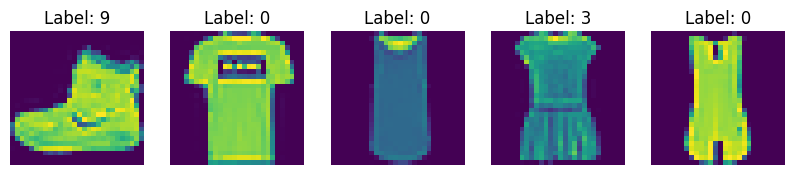

In [12]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.axis('off')
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze().numpy())

As promised, we have images of clothing (they show up with a non black and white colormap by default). Remember the goal is to compress the images into a small latent space which encodes the salient information of each image. Of course, we'll need a model to encode the images.

### Model

Below, we'll define an `Encoder` class. The encoder consists of two linear layers and a ReLU activation. We package them into a `Sequential` object which allows us to encode an image in one call.

In [13]:
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, latent_dim) 
    )
 
  def forward(self, x):
    # x is a (batch_size,1,28,28) tensor so we'll convert it to
    # (batch_size, 28*28) tensor so we can pass it to a linear layer.
    x = x.view(-1, 28*28)
    latent = self.layers(x)
    return latent


Once we encoded the image into a latent space, we'll also need a decoder to decode back into the pixel space we understand. Basically, the image decoder looks the same except that we're going from a small dimension to a big dimension now. We apply the sigmoid activation at the end to force the values between -1 and 1 (so we can interpret them as pixels).

In [14]:
class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super(Decoder, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(latent_dim, 512),
      nn.ReLU(),
      nn.Linear(512, 28*28),
      nn.Sigmoid()
    )

  def forward(self, latent):
    x = self.layers(latent)
    return x.view(-1, 1, 28, 28)

### Initialization

The next step is to initialize our encoder, decoder, and optimizer. We'll also specify the number of epochs that we'll train for and define `device` so we can use a GPU if it's available.

Remember, the GPU is another device so if we do any computation on it, we'll need to make sure both our data and models are on it. 

In [26]:
num_epochs = 20
latent_dim = 2 # A very small latent dimension so we can see what's going on.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 1. Model
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
# 3. Optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

### Training

Now we're ready to train. We'll run for `num_epochs` and, in each epoch, iterate over all 60k images in the training data set.

For each batch of images, we will:

* Put the images on the device.

* Zero the gradient so we don't accumulate old directions.

* Compute the latent representation with our encoder.

* Reconstruct the image from the latent representation using our decoder.

* Compute the loss as the difference between the original and reconstructed images.

* Backpropagate and take a step away from the gradient.

Note: When I ran it on colab.research.google.com, training for 20 epochs took about 2 minutes on the GPU and 6 minutes on the CPU.

In [27]:
for epoch in range(num_epochs):
  train_loss = 0
  for images, _ in train_loader:
    # Put the images on the device.
    images = images.to(device)
    # Zero out the gradient (with a call to the optimizer).
    optimizer.zero_grad()
    # 1. Architecture
    # Compute the latent representation.
    latent = encoder(images)
    # Compute the reconstructed images
    reconstructed = decoder(latent)
    # 2. Loss
    loss = ((images - reconstructed)**2).sum()
    # Backpropagate.
    loss.backward()
    # 3. Optimizer
    # Take a step with our optimizer.
    optimizer.step()
    train_loss += loss.item() / len(train_loader)
  print(f'Epoch: {epoch} \t Train Loss: {train_loss}')

Epoch: 0 	 Train Loss: 50679.04641154658
Epoch: 1 	 Train Loss: 30495.815843485165
Epoch: 2 	 Train Loss: 27960.84775556145
Epoch: 3 	 Train Loss: 26869.458653336867
Epoch: 4 	 Train Loss: 26084.57279528602
Epoch: 5 	 Train Loss: 25575.332858845333
Epoch: 6 	 Train Loss: 25176.495944782848
Epoch: 7 	 Train Loss: 24861.952595338982
Epoch: 8 	 Train Loss: 24566.63908567268
Epoch: 9 	 Train Loss: 24332.077860169495
Epoch: 10 	 Train Loss: 24155.34331965042
Epoch: 11 	 Train Loss: 23978.176459878174
Epoch: 12 	 Train Loss: 23826.887430481987
Epoch: 13 	 Train Loss: 23690.928197828387
Epoch: 14 	 Train Loss: 23569.77836996822
Epoch: 15 	 Train Loss: 23517.69211798199
Epoch: 16 	 Train Loss: 23403.501357256366
Epoch: 17 	 Train Loss: 23311.34146583686
Epoch: 18 	 Train Loss: 23261.072828389828
Epoch: 19 	 Train Loss: 23155.775854078387


We've watched the loss go down but it's not immediately clear that the autoencoder now work. Let's compress some images and visualize them by label in the latent space.

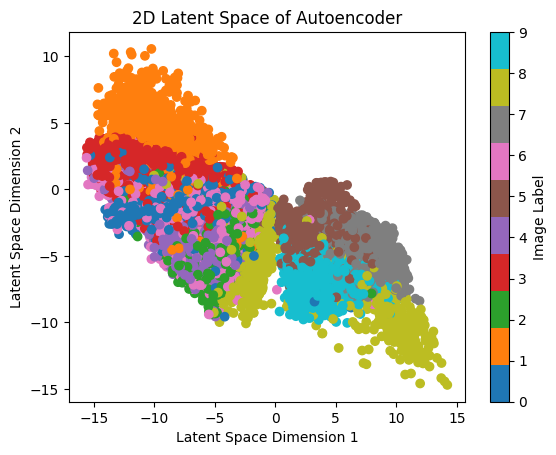

In [28]:
for images, labels in test_loader:
  # Compute the latent representation from the images.
  latent = encoder(images.to(device))
  # Put on the CPU, detach the gradient, and convert to numpy so we can plot.
  latent = latent.cpu().detach().numpy()
  plt.scatter(latent[:,0], latent[:,1], c=labels, cmap='tab10')
plt.colorbar(label='Image Label')
plt.title('2D Latent Space of Autoencoder')
plt.ylabel('Latent Space Dimension 2')
plt.xlabel('Latent Space Dimension 1')
plt.savefig('encoder_clusters.pdf')
plt.show()

It looks like the encoder is doing something! Images of the same label are clustered together. Unfortunately, the clusters overlap and are not well spread through the space. Let's try *sampling* from the latent space and seeing what images we can generate.

Note: Due to the randomness in the training process, the latent space will look different with every run. You should update the below ranges with the appropriate values from your plot.

In [24]:
# Appropriate ranges for decoding from latent space.
r0 = (latent[:,0].min(), latent[:,0].max()) # The min and max x values in the plot.
r1 = (latent[:,1].min(), latent[:,1].max()) # The min and max y values in the plot.

Now, using a clever function from a nice blog post [here](https://avandekleut.github.io/vae), we will build Fashion MNIST images from samples in this range.

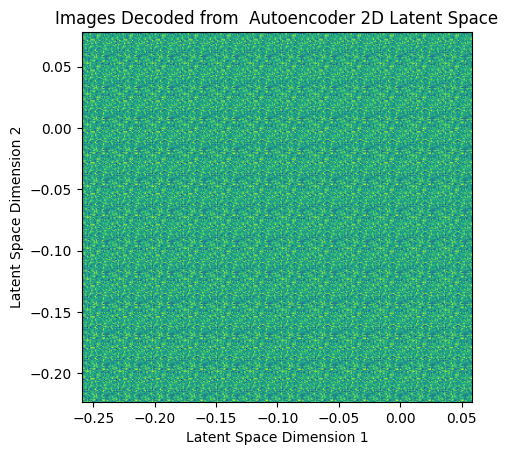

In [25]:
def plot_reconstructed(decoder, r0, r1, encoder_type, n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).cpu().detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.title(f'Images Decoded from {encoder_type} Autoencoder 2D Latent Space')
    plt.ylabel('Latent Space Dimension 2')
    plt.xlabel('Latent Space Dimension 1')
    plt.imshow(img, extent=[*r0, *r1])


plot_reconstructed(decoder, r0, r1, encoder_type='')
plt.savefig('encoder_reconstructed.pdf')

In my case, there are certainly some areas of the latent space that generate realistic looking clothing. However, a random sample would be quite likely to give me a poor image.

Can you match the reconstructed images from the latent space (prior plot) with the clusters in the latent space (plot before the prior plot)?

## Variational Autoencoders

We used autoencoders to compress images into a low-dimensional subspace and generate new images but we're left with a nagging issue: the distribution in the latent space is not well behaved and a random sample does not often give us a nice image.

The idea of *variational* autoencoders is to encourage the distribution of the images in the latent space to be well behaved. In particular, we'll make two changes:

* The output of the encoder will be a mean and standard deviation that we will sample a latent vector from. Note: It's not immediately obvious how to backpropagate through a sample.

* We will add a loss term which is the difference between the mean and standard deviation output by our encoder and the unit normal distribution.

To solve the problem of backpropagating, we'll define the latent vector output of the encoder as

$$z = \mu + \sigma \epsilon$$

where $\mu$ and $\sigma$ are the mean and standard deviation output from the encoding of an image while $\epsilon \sim N(0,1)$ is sampled from a unit normal distribution. If you'd like, you can find more details on this "reparameterization trick" [here](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important).

Let's check out a depiction of the change in the model. (Figure from [here](https://en.wikipedia.org/wiki/File:Reparameterized_Variational_Autoencoder.png).)

![](https://upload.wikimedia.org/wikipedia/commons/1/11/Reparameterized_Variational_Autoencoder.png)

Fortunately, we can use the same decoder as before. Unfortunately, the encoder will get a little messy to implement the change. In particular, we'll apply a layer and ReLU like before. But then we'll have one layer which builds a mean $\mu$ and another layer which builds a standard deviation $\sigma$. The variational encoder will output both and then we'll use them to generate a latent variable $z$ as described above.

In [ ]:
class VariationalEncoder(nn.Module):
  def __init__(self, latent_dim):
    super(VariationalEncoder, self).__init__()
    self.layer_intermediate = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU()
    )
    self.linear_mu = nn.Linear(512, latent_dim)
    self.linear_sigma = nn.Linear(512, latent_dim)
 
  def forward(self, x):
    x = x.view(-1, 28*28)
    intermediate = self.layer_intermediate(x)
    mu = self.linear_mu(intermediate)
    sigma = self.linear_sigma(intermediate)
    sigma = torch.exp(sigma) # Make standard deviation positive
    return mu, sigma


### Initialization

AS before, we'll initialize the encoder, decoder, and optimizer. In addition, so we can sample from the unit normal distribution quickly, we'll put it on `device`.

In [ ]:
latent_dim = 2
encoder = VariationalEncoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

# Put the unit normal distribution on the device.
# Solution from: https://github.com/pytorch/pytorch/issues/7795
unit_normal = torch.distributions.Normal(0, 1)
unit_normal.loc = unit_normal.loc.to(device)
unit_normal.scale = unit_normal.scale.to(device)

### Training

Now, we're ready for training. We'll follow similar steps to what we did before except that we'll generate the latent variable from a distribution and we'll add a loss term to encourage the distributions to be close to the unit normal distribution.

The particular distribution loss we'll use is called the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence): KL divergence measures the distance between two distributions. We'll use a simplified form which applies in the case that one distribution is a unit normal and the other is a normal distribution with mean $\mu$ and standard deviation $\sigma$:

$$ -\log \sigma + \sigma^2 + \mu^2 -1/2.$$

If you're curious, you can find the derivation for the expression we use [here](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians).

Note: When I ran it on colab.research.google.com, training for 20 epochs took about 2 minutes on the GPU and 5 minutes on the CPU.

In [ ]:
for epoch in range(num_epochs):
  train_loss = 0
  for images, labels in train_loader:
    # Put the images on the device.
    images = images.to(device)
    # Zero the gradient.
    optimizer.zero_grad()
    # Output the mu, sigma from the encoder.
    mu, sigma = encoder(images)
    # Use mu, sigma to generate the the latent vector.
    latent = mu + sigma*unit_normal.sample(mu.shape)
    # Decode the latent vector.
    reconstructed = decoder(latent)

    # Compute the *reconstruction* loss.
    reconstruction_loss = ((images - reconstructed)**2).sum()
    # Compute the distribution loss.
    # Hint: Use torch.log and .sum() appropriately
    KL_loss = (-torch.log(sigma) + sigma ** 2 + mu**2 - 1/2).sum()
    # The total loss is the same of both intermediate losses.
    loss = reconstruction_loss + KL_loss

    # Finally, backpropagate and step!
    loss.backward()
    optimizer.step()
    train_loss += loss.item() / len(train_loader)
  print(f'Epoch: {epoch} \t Train Loss: {train_loss}')

Epoch: 0 	 Train Loss: 63408.70580640891
Epoch: 1 	 Train Loss: 39610.43852621821
Epoch: 2 	 Train Loss: 36390.15922934322
Epoch: 3 	 Train Loss: 35205.426873675846
Epoch: 4 	 Train Loss: 34528.85318458687
Epoch: 5 	 Train Loss: 33939.99708686441
Epoch: 6 	 Train Loss: 33427.790088718226
Epoch: 7 	 Train Loss: 33037.39804025424
Epoch: 8 	 Train Loss: 32635.743147510588
Epoch: 9 	 Train Loss: 32320.285851430086
Epoch: 10 	 Train Loss: 32071.35917637712
Epoch: 11 	 Train Loss: 31917.688360699158
Epoch: 12 	 Train Loss: 31679.071603548735
Epoch: 13 	 Train Loss: 31515.615366790247
Epoch: 14 	 Train Loss: 31332.03204449153
Epoch: 15 	 Train Loss: 31199.38324284957
Epoch: 16 	 Train Loss: 31071.445378707638
Epoch: 17 	 Train Loss: 31003.365598516957
Epoch: 18 	 Train Loss: 30804.082858845337
Epoch: 19 	 Train Loss: 30746.458520921613


Let's again plot the images as represented in the latent space to see if the fancy distributional loss helped.

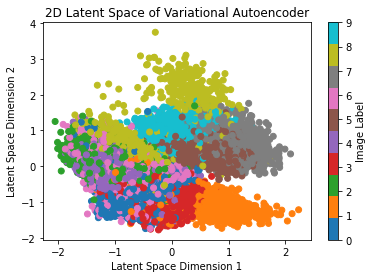

In [ ]:
for images, labels in test_loader:
  mu, sigma = encoder(images.to(device))
  latent = mu + sigma*unit_normal.sample(mu.shape)
  latent = latent.cpu().detach().numpy()
  plt.scatter(latent[:,0], latent[:,1], c=labels, cmap='tab10')
plt.colorbar(label='Image Label')
plt.title('2D Latent Space of Variational Autoencoder')
plt.ylabel('Latent Space Dimension 2')
plt.xlabel('Latent Space Dimension 1')
plt.savefig('variational_encoder_clusters.pdf')
plt.show()


It looks like the fancy distribution did help! Our clusters fill the space better and they overlap a little bit less.

Again, make sure to update the below ranges with the appropriate values from your plot.

In [ ]:
# Appropriate ranges for decoding from latent space.
r0 = (latent[:,0].min(), latent[:,0].max()) # The min and max x values in the plot.
r1 = (latent[:,1].min(), latent[:,1].max()) # The min and max y values in the plot.

We can now plot the reconstructions when we sample from the latent space.

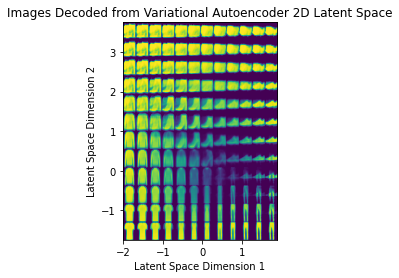

In [ ]:
plot_reconstructed(decoder, r0, r1, encoder_type='Variational')
plt.savefig('variational_encoder_reconstructed.pdf')

As we hoped, we get nice images in more of the space than we did previously!

## Credit

The plots in the autoencoder and variational autoencoder section were inspired by the excellent blog post [here](https://avandekleut.github.io/vae/).